In [4]:
import numpy as np
import pandas as pd
from scipy.special import boxcox, inv_boxcox
from scipy.stats import boxcox_normmax
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import MAE, DistributionLoss
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
df_up = pd.read_csv("../data/5_yr_data/UP5_years.csv")
df_up['datetime'] = pd.to_datetime(df_up['date'])
df_up.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
df_up.sort_values(by="datetime", ascending=True, inplace=True)
df_up.head()

,district_name,market_name,commodity,variety,grade,min_rs_quintal,max_rs_quintal,modal_rs_quintal,date,year,month,day_of_month,datetime
714742,Bijnor,Bijnaur,Onion,Red,FAQ,2950.0,3040.0,3000.0,01 Jan 2018,2018,Jan,1,2018-01-01
433767,Mau(Maunathbhanjan),Kopaganj,Wheat,Dara,FAQ,1525.0,1625.0,1575.0,01 Jan 2018,2018,Jan,1,2018-01-01
439485,Gorakhpur,Gorakhpur,Wheat,Dara,FAQ,1560.0,1590.0,1575.0,01 Jan 2018,2018,Jan,1,2018-01-01
83163,Shahjahanpur,Tilhar,Potato,Potato,FAQ,490.0,510.0,500.0,01 Jan 2018,2018,Jan,1,2018-01-01
730321,Bulandshahar,Divai,Onion,Red,FAQ,2800.0,3000.0,2900.0,01 Jan 2018,2018,Jan,1,2018-01-01


In [6]:
TRAIN_LEN = int(0.8 * len(df_up))
up_train, up_test = (df_up[:TRAIN_LEN],df_up[TRAIN_LEN:])
up_train.set_index('datetime', inplace=True)
up_train.sort_index(inplace=True)
up_test.set_index('datetime', inplace=True)
up_test.sort_index(inplace=True)

In [7]:
commodity = "Rice"
df_train_commodity = up_train[up_train['commodity'] == commodity]
df_train_commodity_dt = df_train_commodity.groupby("datetime").agg({"modal_rs_quintal":"mean"})
df_train_commodity_dt

,modal_rs_quintal
datetime,
2018-01-01,2244.840426
2018-01-02,2261.681818
2018-01-03,2235.193548
2018-01-04,2258.073684
2018-01-05,2291.752941
...,...
2023-04-29,2648.738739
2023-04-30,2665.293103
2023-05-01,2614.902913


In [8]:
df_test_commodity = up_test[up_test['commodity'] == commodity]
df_test_commodity_dt = df_test_commodity.groupby("datetime").agg({"modal_rs_quintal":"mean"})
df_test_commodity_dt.head()

,modal_rs_quintal
datetime,
2023-05-03,2581.857143
2023-05-04,2681.118421
2023-05-05,2662.755102
2023-05-06,2594.227273
2023-05-07,2559.982456


In [9]:
df_train_commodity_dt.reset_index(inplace=True)
df_train_commodity_dt['unique_id'] = commodity
df_train_commodity_dt.rename(columns={"datetime" : "ds", "modal_rs_quintal" : "y"}, inplace=True)
df_train_commodity_dt.head()

,ds,y,unique_id
0,2018-01-01,2244.840426,Rice
1,2018-01-02,2261.681818,Rice
2,2018-01-03,2235.193548,Rice
3,2018-01-04,2258.073684,Rice
4,2018-01-05,2291.752941,Rice


In [10]:
df_test_commodity_dt.reset_index(inplace=True)
df_test_commodity_dt['unique_id'] = commodity
df_test_commodity_dt.rename(columns={"datetime" : "ds", "modal_rs_quintal" : "y"}, inplace=True)
df_test_commodity_dt.head()

,ds,y,unique_id
0,2023-05-03,2581.857143,Rice
1,2023-05-04,2681.118421,Rice
2,2023-05-05,2662.755102,Rice
3,2023-05-06,2594.227273,Rice
4,2023-05-07,2559.982456,Rice


In [11]:
df_train_commodity_dt.shape

(1949, 3)

In [12]:
df_test_commodity_dt.shape

(488, 3)

In [127]:
model = NBEATS(h=368, input_size=120,
               loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
               stack_types = ['identity', 'trend', 'seasonality'],
               max_steps=120,
               val_check_steps=16,
               early_stop_patience_steps=4)

fcst = NeuralForecast(
    models=[model],
    freq='D'
)
# fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
fcst.fit(df=df_train_commodity_dt, val_size=488)
forecasts = fcst.predict(futr_df=df_test_commodity_dt)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 3.9 M  | train
----------------------------------------------------------
3.6 M     Trainable params
359 K     Non-trainable params
3.9 M     Total params
15.664    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=120` reached.
/home/mukundan/learning/ai_ml/sih_2024_project/sih_2024/sihvenv/lib/python3.12/site-packages/neuralforecast/core.py:902: UserWarning: Dropped 120 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/mukundan/learning/ai_ml/sih_2024_project/sih_2024/sihvenv/lib/python3.12/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [128]:
len(forecasts)

368

,ds,y,unique_id,NBEATS,NBEATS-median,NBEATS-lo-90,NBEATS-lo-80,NBEATS-hi-80,NBEATS-hi-90
0,2023-05-03,2581.857143,Rice,2595.201904,2594.5,2513.000000,2529.000000,2658.000000,2678.000000
1,2023-05-04,2681.118421,Rice,2594.333984,2593.0,2517.000000,2531.000000,2656.000000,2674.050049
2,2023-05-05,2662.755102,Rice,2592.501953,2594.0,2509.000000,2525.000000,2654.000000,2671.100098
3,2023-05-06,2594.227273,Rice,2593.382080,2593.0,2513.000000,2530.000000,2656.100098,2678.000000
4,2023-05-07,2559.982456,Rice,2591.391113,2591.0,2510.949951,2526.899902,2656.000000,2677.000000
...,...,...,...,...,...,...,...,...,...
483,2024-08-28,3119.150442,Rice,NaN,NaN,NaN,NaN,NaN,NaN
484,2024-08-29,3136.592233,Rice,NaN,NaN,NaN,NaN,NaN,NaN
485,2024-08-30,3144.841667,Rice,NaN,NaN,NaN,NaN,NaN,NaN
486,2024-08-31,3146.494845,Rice,NaN,NaN,NaN,NaN,NaN,NaN


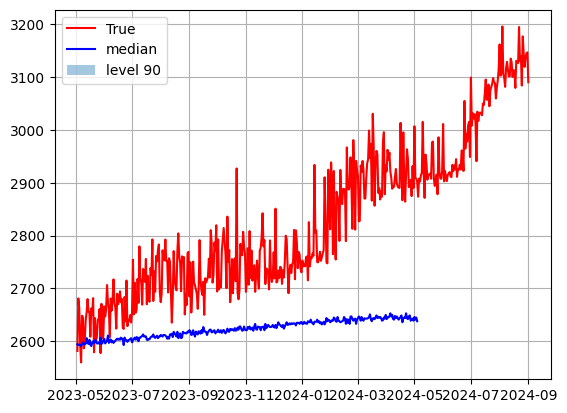

In [129]:
# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])

plot_df = pd.concat([df_test_commodity_dt, Y_hat_df], axis=1)
# plot_df = pd.concat([df_train_commodity_dt, plot_df])

# plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='red', label='True')
plt.plot(plot_df['ds'], plot_df['NBEATS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['NBEATS-lo-90'][-12:].values, 
                 y2=plot_df['NBEATS-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.grid()
plt.legend()
plt.plot()

plot_df

In [130]:
df_test_commodity_dt[:368]

,ds,y,unique_id
0,2023-05-03,2581.857143,Rice
1,2023-05-04,2681.118421,Rice
2,2023-05-05,2662.755102,Rice
3,2023-05-06,2594.227273,Rice
4,2023-05-07,2559.982456,Rice
...,...,...,...
363,2024-04-30,2890.010638,Rice
364,2024-05-01,3006.720000,Rice
365,2024-05-02,2909.326923,Rice
366,2024-05-03,2907.605505,Rice


In [131]:
mae = mean_absolute_error(df_test_commodity_dt[:368]['y'], Y_hat_df['NBEATS-median'])
rmse = np.sqrt(mean_squared_error(df_test_commodity_dt[:368]['y'], Y_hat_df['NBEATS-median']))

In [132]:
print(mae,rmse)

145.87492470580403 169.35277374867988


In [26]:
Y_hat_df.head()

,NBEATS,NBEATS-median,NBEATS-lo-90,NBEATS-lo-80,NBEATS-hi-80,NBEATS-hi-90
0,1128.265015,1128.0,1072.000000,1084.0,1172.099976,1184.050049
1,1123.104004,1123.0,1067.000000,1079.0,1168.000000,1180.000000
2,1125.390015,1124.5,1072.000000,1083.0,1167.000000,1183.000000
3,1126.553955,1126.0,1072.000000,1083.0,1171.000000,1182.000000
4,1127.218994,1127.0,1070.949951,1084.0,1170.000000,1183.000000


In [33]:
df_train_commodity_dt.head()

,ds,y,unique_id
0,2018-01-01,2747.222222,Onion
1,2018-01-02,2757.333333,Onion
2,2018-01-03,2722.439394,Onion
3,2018-01-04,2798.666667,Onion
4,2018-01-05,2753.147541,Onion


In [34]:
df_test_commodity_dt.head()

,ds,y,unique_id
0,2023-05-03,1128.114754,Onion
1,2023-05-04,1117.956522,Onion
2,2023-05-05,1124.852113,Onion
3,2023-05-06,1105.476821,Onion
4,2023-05-07,1106.873786,Onion


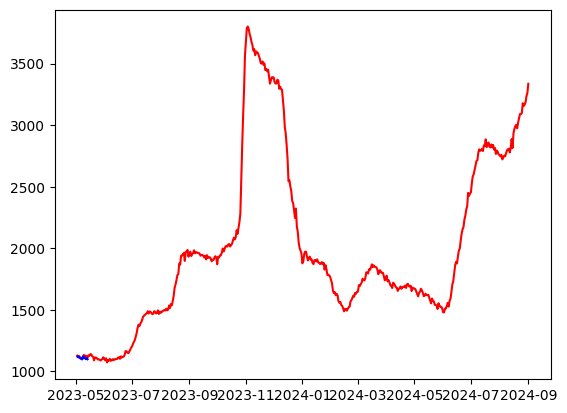

In [39]:
plot_df = pd.concat([df_test_commodity_dt, Y_hat_df], axis=1)
plt.plot(plot_df['ds'], plot_df['y'],  c='red', label='True')
plt.plot(plot_df['ds'], plot_df['NBEATS-median'], c='blue', label='median')

In [ ]:
plot_df = pd.concat([df_train_commodity_dt, plot_df])
plot_df

In [ ]:
use_boxcox = False  # Set to False if not using Box-Cox

# commodities = df_up['commodity'].unique()

# for commodity in commodities:
    # Train-test split
    train_len = int(len(boxcox_diff_dfs[commodity]) * 0.8)
    df_train = boxcox_diff_dfs[commodity][:train_len - 1]

    df_test_commodity = up_test[up_test['commodity'] == commodity]
    df_test_commodity_dt = df_test_commodity.groupby("datetime").agg({"modal_rs_quintal": "mean"})

    if use_boxcox:
        # Box-Cox transformation
        lmbda = boxcox_normmax(df_train)  # Optimize lambda for Box-Cox
        df_test_commodity_boxcox = pd.Series(boxcox(df_test_commodity_dt['modal_rs_quintal'], lmbda=lmbda),
                                             index=df_test_commodity_dt.index)
        df_test = pd.Series(df_test_commodity_boxcox - df_test_commodity_boxcox.shift(), index=df_test_commodity_boxcox.index)
        df_test.dropna(inplace=True)
    else:
        # df_test_commodity_dt.set_index("datetime")
        df_test = df_test_commodity_dt['modal_rs_quintal']

    # Prepare training data
    df_train = df_train.to_frame(name='y')
    df_train['unique_id'] = commodity
    df_train['ds'] = df_train.index

    # Prepare test data for predictions
    df_test_pred = df_test.to_frame(name='y')
    df_test_pred['unique_id'] = commodity
    df_test_pred['ds'] = df_test_pred.index
    input_size = 120  # Use past 14 days to forecast
    horizon = 120    # Forecasting the next 14 days

    # Initialize N-BEATS model
    nbeats_model = NBEATS(
    input_size=input_size,
    h=horizon,
    n_blocks=[2, 2],  # Two blocks each for trend and seasonality
    stack_types=['trend', 'seasonality'],  # Trend and seasonality stacks
    mlp_units=1*[[128, 128]],  # Hidden units for MLP layers in the blocks
    loss=MAE(),  # Mean Absolute Error
    )

    # Initialize NeuralForecast object
    fcst = NeuralForecast(models=[nbeats_model], freq='D')

    # Train the model on the training data
    fcst.fit(df_train)
    forecast = fcst.predict(df_test_pred)

# Prepare actual values and predicted values
    y_hat = df_test.copy()
    y_hat['nbeats_forecast'] = forecast['NBEATS'].values

    # If using Box-Cox, invert the transformation
    if use_boxcox:
        y_hat['nbeats_forecast'] = inv_boxcox(y_hat['nbeats_forecast'].cumsum(), lmbda)
    else:
        y_hat['nbeats_forecast'] = y_hat['nbeats_forecast'].cumsum()

    

In [ ]:
# Plot the results
def plot_results(up_train ,commodity):
    up_train_commodity = up_train[up_train['commodity'] == commodity]
    up_train_commodity_dt = up_train_commodity.groupby("datetime").agg({"modal_rs_quintal": "mean"})
    up_test_commodity_dt = up_test[up_test['commodity'] == commodity].groupby("datetime").agg({"modal_rs_quintal": "mean"})

    plt.plot(up_train_commodity_dt, label="Train")
    plt.plot(up_test_commodity_dt, label="Test")
    plt.plot(y_hat['nbeats_forecast'], label="N-BEATS forecast")
    plt.legend(loc="best")
    plt.show()
    mae = mean_absolute_error(df_test[:horizon], y_hat['nbeats_forecast'])
    rmse = np.sqrt(mean_squared_error(df_test[:horizon], y_hat['nbeats_forecast']))
    print(y_hat.index,y_hat['nbeats_forecast'])

    print(f'N-BEATS Mean Absolute Error (MAE): {mae:.4f}')
    print(f'N-BEATS Root Mean Squared Error (RMSE): {rmse:.4f}')

In [1]:
from darts.models.forecasting.nbeats import NBEATSModel
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, DeepAR, TFT, LSTM, RNN, GRU
from neuralforecast.losses.pytorch import DistributionLoss, MAE, MSE, MAPE, SMAPE
import torch

from darts import TimeSeries
from darts.models import (
    NBEATSModel,
    NHiTSModel,
    BlockRNNModel,
    TCNModel,
    TiDEModel,
    TransformerModel,
    RandomForest,
    LightGBMModel,
    XGBModel,
    Prophet,
)

In [28]:
# Required imports
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, DeepAR, TFT, LSTM, RNN, GRU
from neuralforecast.losses.pytorch import DistributionLoss, MAE, MSE, MAPE, SMAPE
import torch

from darts import TimeSeries
from darts.models import (
    NBEATSModel,
    NHiTSModel,
    BlockRNNModel,
    TCNModel,
    TiDEModel,
    TransformerModel,
    RandomForest,
    LightGBMModel,
    XGBModel,
    Prophet,
)


def create_nixtla_models(input_size=120, output_size=368):
    """
    Create a collection of Nixtla models with correct parameters
    """
    # Common parameters
    common_params = {
        "input_size": input_size,
        "h": output_size,
        "max_steps": 100,
        "val_check_steps": 16,
        "early_stop_patience_steps": 4,
    }

    # N-BEATS model
    nbeats = NBEATS(
        **common_params,
        loss=DistributionLoss(distribution="Normal", level=[80, 90]),
        stack_types=["trend", "seasonality"],
        num_blocks=[3, 3],
        num_layers=[4, 4],
        layer_widths=[256, 2048],
        expansion_coefficient_lengths=[5, 7],
        trend_polynomial_degree=2,
    )

    # N-HiTS model
    nhits = NHITS(
        **common_params,
        loss=DistributionLoss(distribution="Normal", level=[80, 90]),
        num_stacks=3,  # Default is 3
        hidden_size=128,  # Units per hidden layer
        n_freq_downsample=[168, 24, 1],  # Pooling factor per stack
        pooling_kernel_sizes=[168, 24, 1],
        interpretation=False,
        activation="ReLU",
    )

    # DeepAR model
    deepar = DeepAR(
        **common_params,
        loss=DistributionLoss(distribution="StudentT", level=[80, 90]),
        hidden_size=128,
        rnn_layers=2,
        dropout=0.1,
        cell_type="LSTM",
    )

    # Temporal Fusion Transformer
    tft = TFT(
        **common_params,
        loss=DistributionLoss(distribution="Normal", level=[80, 90]),
        hidden_size=128,  # Hidden state size
        lstm_hidden_size=64,  # Size of LSTM hidden states
        num_attention_heads=4,  # Number of attention heads
        dropout=0.1,  # Dropout rate
        hidden_continuous_size=64,  # Size for processing continuous variables
    )

    # LSTM model
    lstm = LSTM(
        **common_params,
        loss=MSE(),
        hidden_size=128,
        num_layers=2,
        dropout=0.1,
        batch_normalization=True,
    )

    # RNN model
    rnn = RNN(
        **common_params,
        loss=MAE(),
        hidden_size=128,
        num_layers=2,
        dropout=0.1,
        cell_type="GRU",
    )

    # GRU model
    gru = GRU(**common_params, loss=SMAPE(), hidden_size=128, num_layers=2, dropout=0.1)

    # Create NeuralForecast object with all models
    fcst = NeuralForecast(models=[nbeats, nhits, deepar, tft, lstm, rnn, gru], freq="D")

    return fcst


def create_darts_models(input_chunk_length=120, output_chunk_length=30, n_epochs=100):
    """
    Create a collection of Darts models with correct parameters
    """
    # Common parameters for neural networks
    nn_params = {
        "input_chunk_length": input_chunk_length,
        "output_chunk_length": output_chunk_length,
        "n_epochs": n_epochs,
        "batch_size": 32,
        "force_reset": True,
    }

    models = {
        # Neural network based models
        "nbeats": NBEATSModel(
            **nn_params,
            generic_architecture=False,
            num_stacks=2,
            num_blocks=3,
            num_layers=4,
            layer_widths=256,
            expansion_coefficient_dim=5,
            trend_polynomial_degree=2,
        ),
        "nhits": NHiTSModel(
            **nn_params,
            num_stacks=3,
            num_blocks=1,
            num_layers=2,
            layer_widths=512,
            pooling_kernel_sizes=None,
            n_freq_downsample=None,
            dropout=0.1,
            activation="ReLU",
            MaxPool1d=True,
        ),
        "block_rnn": BlockRNNModel(
            **nn_params,
            model="LSTM",
            hidden_dim=128,
            n_rnn_layers=2,
            dropout=0.1,
        ),
        "tcn": TCNModel(
            **nn_params,
            num_filters=64,
            kernel_size=3,
            dilation_base=2,
            dropout=0.1,
            weight_norm=True,
        ),
        "tide": TiDEModel(
            **nn_params,
            num_encoder_layers=2,
            num_decoder_layers=2,
            temporal_width_past=24,
            temporal_width_future=12,
            temporal_decoder_hidden=32,
        ),
        "transformer": TransformerModel(
            **nn_params,
            d_model=64,
            nhead=4,
            num_encoder_layers=3,
            num_decoder_layers=3,
            dim_feedforward=256,
            dropout=0.1,
            activation="gelu",
        ),
        # Traditional ML models
        "random_forest": RandomForest(
            lags=input_chunk_length,
            n_estimators=100,
            max_depth=None,
            min_samples_split=2,
        ),
        
        "xgboost": XGBModel(
            lags=input_chunk_length, n_estimators=100, max_depth=6, learning_rate=0.1
        ),
        
    }

    return models


def train_and_forecast(df_train, df_test, use_nixtla=True):
    """
    Train models and generate forecasts using either Nixtla or Darts
    """
    if use_nixtla:
        # Nixtla workflow
        fcst = create_nixtla_models()

        # Ensure df_train has the required columns
        if "unique_id" not in df_train.columns:
            df_train["unique_id"] = "series0"
        if "ds" not in df_train.columns:
            df_train = df_train.rename(columns={"date": "ds"})
        if "y" not in df_train.columns:
            df_train = df_train.rename(columns={"value": "y"})

        # Similarly for test data
        if "unique_id" not in df_test.columns:
            df_test["unique_id"] = "series0"
        if "ds" not in df_test.columns:
            df_test = df_test.rename(columns={"date": "ds"})
        if "y" not in df_test.columns:
            df_test = df_test.rename(columns={"value": "y"})

        fcst.fit(df=df_train, val_size=488)
        forecasts = fcst.predict(futr_df=df_test)
        return forecasts
    else:
        # Darts workflow
        # Convert pandas DataFrame to Darts TimeSeries
        series = TimeSeries.from_dataframe(df_train, "ds", "y")

        # Create and train models
        models = create_darts_models()
        forecasts = {}

        for name, model in models.items():
            print(f"Training {name} model...")
            model.fit(series)
            forecast = model.predict(len(df_test))
            forecasts[name] = forecast

        return forecasts


# Example usage:
"""
# For Nixtla models
nixtla_forecasts = train_and_forecast(df_train_commodity_dt, df_test_commodity_dt, use_nixtla=True)

# For Darts models
darts_forecasts = train_and_forecast(df_train_commodity_dt, df_test_commodity_dt, use_nixtla=False)
"""

'\n# For Nixtla models\nnixtla_forecasts = train_and_forecast(df_train_commodity_dt, df_test_commodity_dt, use_nixtla=True)\n\n# For Darts models\ndarts_forecasts = train_and_forecast(df_train_commodity_dt, df_test_commodity_dt, use_nixtla=False)\n'

In [ ]:
y_train = df_train_commodity_dt['y']


,ds,y,unique_id
0,2018-01-01,2244.840426,Rice
1,2018-01-02,2261.681818,Rice
2,2018-01-03,2235.193548,Rice
3,2018-01-04,2258.073684,Rice
4,2018-01-05,2291.752941,Rice
...,...,...,...
1944,2023-04-29,2648.738739,Rice
1945,2023-04-30,2665.293103,Rice
1946,2023-05-01,2614.902913,Rice
1947,2023-05-02,2653.594340,Rice


In [29]:
nixtla_forecasts = train_and_forecast(
    df_train_commodity_dt, df_test_commodity_dt, use_nixtla=False
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 511 K  | train
-------------------------------------------------------------
465 K     Trainable params
46.2 K    Non-trainable params
511 K     Total params
2.048     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training nbeats model...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 968 K  | train
-------------------------------------------------------------
907 K     Trainable params
61.6 K    Non-trainable params
968 K     Total params
3.876     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


Training nhits model...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 3.9 K  | train
-------------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.812     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training block_rnn model...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/shri/learning/sih/krushiJyothishii/sih_2024/.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 100 K  | train
-------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total 

Training tcn model...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 97.0 K | train
6 | decoders         | Sequential       | 189 K  | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 3.6 K  | train
--------------------------------------------------------------
291 K     Trainable params
0         Non-trainable params
291 K     Total params
1.165     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode

Training tide model...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/shri/learning/sih/krushiJyothishii/sih_2024/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encode

Training transformer model...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Training random_forest model...
Training xgboost model...


In [56]:
pd.DataFrame(nixtla_forecasts['nbeats'].values())[0]

0      2639.336968
1      2615.778797
2      2625.001630
3      2640.623159
4      2627.402201
          ...     
483    2587.269912
484    2590.076444
485    2600.148479
486    2589.232662
487    2588.094290
Name: 0, Length: 488, dtype: float64

In [57]:
for model,data in nixtla_forecasts.items():
    nixtla_forecasts[model] = pd.DataFrame(nixtla_forecasts[model].values())[0]

In [63]:
result = pd.DataFrame(nixtla_forecasts)

In [62]:
result_y = df_test_commodity_dt['y']

In [65]:
results = pd.concat([result,result_y],axis=1)

In [68]:
from sklearn.metrics import r2_score,mean_absolute_error,root_mean_squared_error


In [69]:
scores = dict()
def get_scores(y_test,y_pred):
    r2_ = r2_score(y_test,y_pred)
    rmse_ = root_mean_squared_error(y_test,y_pred)
    mae_ = mean_absolute_error(y_test,y_pred)
    return {"r2":r2_,"mae":mae_,"rmse":rmse_}

for column in results.columns:
    scores[column] = get_scores(results['y'],results[column])
    

In [71]:
error_results = pd.DataFrame(scores)

In [72]:
error_results

,nbeats,nhits,block_rnn,tcn,tide,transformer,random_forest,xgboost,y
r2,-2.858596,0.622224,-216.787346,-3.815459,-12.353250,-5.613384,-2.244520,-2.108049,1.0
mae,243.634457,69.186309,2119.536115,270.742486,449.024769,341.071885,216.435564,211.340449,0.0
rmse,282.773321,88.479182,2124.418492,315.894878,526.038141,370.199337,259.297877,253.786020,0.0


In [73]:
import plotly.express as px

In [74]:
results

,nbeats,nhits,block_rnn,tcn,tide,transformer,random_forest,xgboost,y
0,2639.336968,2653.230303,710.138357,2580.518687,2604.953966,2486.502202,2630.146968,2643.024902,2581.857143
1,2615.778797,2638.955902,710.239955,2568.782519,2579.403687,2485.819318,2626.574603,2628.471680,2681.118421
2,2625.001630,2643.868973,709.422079,2573.648236,2588.591348,2486.371934,2620.828067,2614.609375,2662.755102
3,2640.623159,2654.309072,708.978935,2560.797425,2571.545978,2487.018019,2637.429418,2645.827637,2594.227273
4,2627.402201,2658.819573,709.949752,2572.390107,2581.619820,2486.842971,2628.340933,2636.524414,2559.982456
...,...,...,...,...,...,...,...,...,...
483,2587.269912,2946.078736,709.617384,2522.228113,2154.213171,2489.884413,2613.659210,2606.017822,3119.150442
484,2590.076444,2941.193001,710.092416,2522.135847,2184.343918,2490.600726,2613.796079,2607.115723,3136.592233
485,2600.148479,2944.857798,711.388638,2522.224491,2159.356902,2489.891028,2613.434186,2613.418945,3144.841667
486,2589.232662,2938.132331,710.522727,2523.115160,2177.695241,2490.892367,2613.581054,2622.374023,3146.494845


In [81]:


px.line(results,x=results.index,y=['y','nbeats','nhits','tcn','tide','transformer','random_forest','xgboost'])

In [82]:
df_train_commodity_dt

,ds,y,unique_id
0,2018-01-01,2244.840426,Rice
1,2018-01-02,2261.681818,Rice
2,2018-01-03,2235.193548,Rice
3,2018-01-04,2258.073684,Rice
4,2018-01-05,2291.752941,Rice
...,...,...,...
1944,2023-04-29,2648.738739,Rice
1945,2023-04-30,2665.293103,Rice
1946,2023-05-01,2614.902913,Rice
1947,2023-05-02,2653.594340,Rice


In [84]:
px.line(df_train_commodity_dt,x=df_train_commodity_dt.ds,y='y')